# Updated KGAT Model with Training, Validation, and Testing
This notebook implements the KGAT model with training, validation, and testing datasets, and plots the loss curves for both training and validation sets.

## Data Loading and Preprocessing

In [122]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the knowledge graph CSV
kg_df = pd.read_csv('knowledge_graph_movies_1k.csv')

# Ensure the 'head', 'relation', and 'tail' columns are of categorical type
kg_df['head'] = kg_df['head'].astype('category')
kg_df['relation'] = kg_df['relation'].astype('category')
kg_df['tail'] = kg_df['tail'].astype('category')

# Convert entities and relations to categorical codes
head_codes = kg_df['head'].cat.codes
relation_codes = kg_df['relation'].cat.codes
tail_codes = kg_df['tail'].cat.codes

# Extract relevant tensors for KGAT
heads = torch.tensor(head_codes.values, dtype=torch.long)
relations = torch.tensor(relation_codes.values, dtype=torch.long)
tails = torch.tensor(tail_codes.values, dtype=torch.long)

# Split the data into training, validation, and testing datasets
heads_train, heads_temp, relations_train, relations_temp, tails_train, tails_temp = train_test_split(
    heads, relations, tails, test_size=0.4, random_state=42)

heads_val, heads_test, relations_val, relations_test, tails_val, tails_test = train_test_split(
    heads_temp, relations_temp, tails_temp, test_size=0.5, random_state=42)

# Check the size of each split
print(f"Training size: {len(heads_train)}, Validation size: {len(heads_val)}, Testing size: {len(heads_test)}")

Training size: 61735, Validation size: 20579, Testing size: 20579


In [102]:
def percentage_of_ones(tensor):
    # Count the number of 1s
    num_ones = torch.sum(tensor == 4).item()
    
    # Calculate the total number of elements
    total_elements = tensor.numel()
    
    # Calculate the percentage of 1s
    percentage = (num_ones / total_elements) * 100
    
    return percentage

# Example usage
percentage = percentage_of_ones(relations_test)
print(f"Percentage of 4s: {percentage:.2f}%")

Percentage of 4s: 97.22%


In [103]:
def create_batches(heads, relations, tails, batch_size):
    num_batches = len(heads) // batch_size
    for i in range(num_batches):
        yield (heads[i * batch_size:(i + 1) * batch_size],
               relations[i * batch_size:(i + 1) * batch_size],
               tails[i * batch_size:(i + 1) * batch_size])
    
    if len(heads) % batch_size != 0:
        yield (heads[num_batches * batch_size:],
               relations[num_batches * batch_size:],
               tails[num_batches * batch_size:])

## KGAT Model

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [105]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embedding_dim * 2, embedding_dim),
                nn.ReLU(),
                nn.Linear(embedding_dim, 1)
            ) for _ in range(num_heads)
        ])

    def forward(self, head_emb, relation_emb, neighbor_emb):
        attention_scores = []
        for attention_head in self.attention_heads:
            # Compute neighbor-specific attention scores
            neighbor_input = torch.cat([head_emb, neighbor_emb], dim=-1)
            neighbor_att_scores = attention_head(neighbor_input)
            
            # Compute relation-specific attention scores
            relation_att_scores = attention_head(relation_emb)
            
            # Combine the two attention scores
            scores = torch.sigmoid(neighbor_att_scores + relation_att_scores)
            attention_scores.append(scores)

        # Concatenate or average the attention scores from all heads
        multi_head_attention_scores = torch.cat(attention_scores, dim=-1)
        return multi_head_attention_scores, attention_scores  # Returning both the combined and individual attention scores


In [106]:
class KGATEmbedding(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, n_layers, num_heads, dropout_rate=0.2):
        super(KGATEmbedding, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        self.layers = n_layers
        
        # GCN layers to propagate the information with residual connections
        self.gcn_layers = nn.ModuleList([nn.Linear(embedding_dim, embedding_dim) for _ in range(n_layers)])
        
        # Multi-Head Attention mechanism
        self.multi_head_attention = MultiHeadAttention(embedding_dim, num_heads)
        
        # Layer normalization instead of batch normalization
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, heads, relations, tails, neighbors=None):
        head_emb = self.entity_embedding(heads)
        relation_emb = self.relation_embedding(relations)
        tail_emb = self.entity_embedding(tails)
        
        # Propagate embeddings through GCN layers with residual connections
        for gcn_layer in self.gcn_layers:
            residual = head_emb
            head_emb = F.relu(gcn_layer(head_emb))
            relation_emb = F.relu(gcn_layer(relation_emb))
            tail_emb = F.relu(gcn_layer(tail_emb))
            
            # Apply residual connection
            head_emb = head_emb + residual
            relation_emb = relation_emb + residual
            tail_emb = tail_emb + residual
            
            # Apply layer normalization and dropout
            head_emb = self.layer_norm(head_emb)
            relation_emb = self.layer_norm(relation_emb)
            tail_emb = self.layer_norm(tail_emb)
            
            head_emb = self.dropout(head_emb)
            relation_emb = self.dropout(relation_emb)
            tail_emb = self.dropout(tail_emb)
        
        individual_attention_scores = None  # Initialize as None

        if neighbors is not None:
            neighbor_emb = self.entity_embedding(neighbors)
            attention_weights, individual_attention_scores, relation_attention_scores = self.multi_head_attention(head_emb, relation_emb, neighbor_emb)
            weighted_neighbor_emb = attention_weights * neighbor_emb
            aggregated_emb = weighted_neighbor_emb.sum(dim=1)
        else:
            aggregated_emb = head_emb
        
        # Final score calculation
        score = torch.sum(aggregated_emb * tail_emb, dim=-1)  # Dot product as a score
        return score, individual_attention_scores  # Ensure individual_attention_scores is returned


In [107]:
class KGATModel(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, n_layers=2, num_heads=8, dropout_rate=0.2):
        super(KGATModel, self).__init__()
        self.kgat_embedding = KGATEmbedding(num_entities, num_relations, embedding_dim, n_layers, num_heads, dropout_rate)
        self.linear = nn.Linear(embedding_dim, embedding_dim)  # Linear layer for final combination
        self.activation = nn.ReLU()

    def forward(self, heads, relations, tails, negative_tails=None, neighbors=None):
        pos_score, individual_attention_scores = self.kgat_embedding(heads, relations, tails, neighbors)

        if negative_tails is not None:
            neg_score, _ = self.kgat_embedding(heads, relations, negative_tails, neighbors)
            return pos_score, neg_score, individual_attention_scores  # Return attention scores

        return pos_score, individual_attention_scores


#### Integerate MarginRankingLoss

In [108]:
class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()

    def forward(self, pos_score, neg_score):
        # BPR loss function
        loss = -F.logsigmoid(pos_score - neg_score).mean()
        return loss

In [109]:
import torch.nn.functional as F

class MarginRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MarginRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, pos_score, neg_score):
        # Margin-based ranking loss
        loss = F.relu(self.margin - pos_score + neg_score).mean()
        return loss

In [110]:
class SmoothNDCGLoss(nn.Module):
    def __init__(self, k=10):
        super(SmoothNDCGLoss, self).__init__()
        self.k = k

    def forward(self, pos_score, neg_score):
        # Stack positive and negative scores
        scores = torch.stack([pos_score, neg_score], dim=1)  # (batch_size, 2)
        
        # Apply softmax to approximate the ranking positions
        softmax_scores = F.softmax(scores, dim=1)  # (batch_size, 2)

        # Compute DCG for positive and negative items
        ranks = torch.arange(1, 3, dtype=torch.float32, device=scores.device).unsqueeze(0)
        dcg_pos = (softmax_scores[:, 0] / torch.log2(ranks[:, 0] + 1)).sum(dim=-1)
        dcg_neg = (softmax_scores[:, 1] / torch.log2(ranks[:, 1] + 1)).sum(dim=-1)

        # Compute ideal DCG
        ideal_dcg = 1.0 / torch.log2(ranks + 1).sum()

        # Compute NDCG
        ndcg = (dcg_pos + dcg_neg) / ideal_dcg

        # Return the mean NDCG loss
        return 1.0 - ndcg.mean()


## Model Training with Validation

In [111]:
# Instantiate the model with added dropout and batch normalization
embedding_dim = 60  # Adjust as necessary
num_entities = len(kg_df['head'].cat.categories) + len(kg_df['tail'].cat.categories)
num_relations = len(kg_df['relation'].cat.categories)
kgat_model = KGATModel(num_entities, num_relations, embedding_dim, dropout_rate=0.3)

def train_kgat_with_validation(model, heads_train, relations_train, tails_train, 
                               heads_val, relations_val, tails_val, 
                               epochs=10, batch_size=512, lr=0.001, loss_type='margin', k=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Select the loss function based on user input
    if loss_type == 'margin':
        criterion = MarginRankingLoss(margin=1.0)
    elif loss_type == 'ndcg':
        criterion = SmoothNDCGLoss(k=k)
    elif loss_type == 'bpr':
        criterion = BPRLoss()
    else:
        raise ValueError("loss_type should be either 'margin', 'ndcg', or 'bpr'")

    train_loss_values = []
    val_loss_values = []
    attention_weights_epoch = []

    for epoch in range(epochs):
        model.train()
        train_batch_losses = []
        for batch_heads, batch_relations, batch_tails in create_batches(heads_train, relations_train, tails_train, batch_size):
            optimizer.zero_grad()

            # Generate negative samples by randomly corrupting the tail
            negative_tails_batch = torch.randint(0, num_entities, batch_tails.size(), device=batch_tails.device)

            # Forward pass for both positive and negative samples
            pos_score, neg_score, attention_weights = model(batch_heads, batch_relations, batch_tails, negative_tails_batch)

            # Apply the selected loss function
            loss = criterion(pos_score, neg_score)

            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

        # Store the average loss for this epoch
        avg_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        train_loss_values.append(avg_train_loss)

        # Store attention weights for this epoch
        attention_weights_epoch.append(attention_weights)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_batch_losses = []
            for batch_heads, batch_relations, batch_tails in create_batches(heads_val, relations_val, tails_val, batch_size):
                negative_tails_batch = torch.randint(0, num_entities, batch_tails.size(), device=batch_tails.device)
                
                pos_score, neg_score, _ = model(batch_heads, batch_relations, batch_tails, negative_tails_batch)
                
                loss = criterion(pos_score, neg_score)
                val_batch_losses.append(loss.item())

        avg_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        val_loss_values.append(avg_val_loss)

        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_loss_values, val_loss_values, attention_weights_epoch



# Train the model with training and validation loss tracking
train_loss_values, val_loss_values, attention_weights_epoch = train_kgat_with_validation(
    kgat_model, heads_train, relations_train, tails_train,
    heads_val, relations_val, tails_val, epochs=30, batch_size=256, loss_type='bpr', k=10)


Epoch 1, Train Loss: 2.7968, Val Loss: 0.6827
Epoch 2, Train Loss: 0.7004, Val Loss: 0.6833
Epoch 3, Train Loss: 0.4624, Val Loss: 0.1860
Epoch 4, Train Loss: 0.2030, Val Loss: 0.1470
Epoch 5, Train Loss: 0.1767, Val Loss: 0.1353
Epoch 6, Train Loss: 0.1644, Val Loss: 0.1300
Epoch 7, Train Loss: 0.1581, Val Loss: 0.1264
Epoch 8, Train Loss: 0.1555, Val Loss: 0.1250
Epoch 9, Train Loss: 0.1521, Val Loss: 0.1227
Epoch 10, Train Loss: 0.1498, Val Loss: 0.1209
Epoch 11, Train Loss: 0.1488, Val Loss: 0.1222
Epoch 12, Train Loss: 0.1461, Val Loss: 0.1201
Epoch 13, Train Loss: 0.1472, Val Loss: 0.1197
Epoch 14, Train Loss: 0.1466, Val Loss: 0.1203
Epoch 15, Train Loss: 0.1447, Val Loss: 0.1182
Epoch 16, Train Loss: 0.1443, Val Loss: 0.1195
Epoch 17, Train Loss: 0.1443, Val Loss: 0.1189
Epoch 18, Train Loss: 0.1419, Val Loss: 0.1183
Epoch 19, Train Loss: 0.1428, Val Loss: 0.1176
Epoch 20, Train Loss: 0.1425, Val Loss: 0.1178
Epoch 21, Train Loss: 0.1419, Val Loss: 0.1175
Epoch 22, Train Loss: 

In [95]:
def plot_loss_curve(train_loss_values, val_loss_values):
    # Plot the training and validation loss curves
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

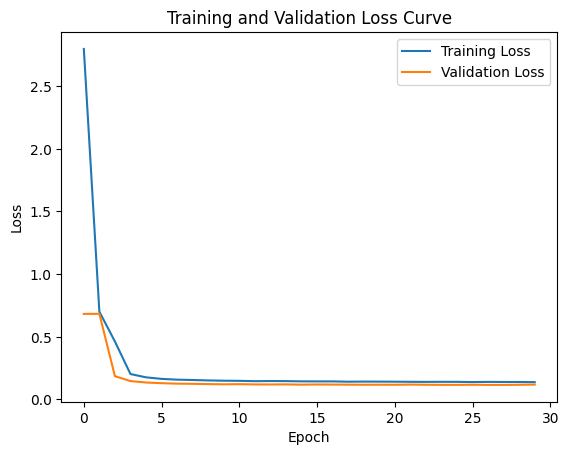

In [112]:
# Plot the loss curves
plot_loss_curve(train_loss_values, val_loss_values)

In [ ]:
import seaborn as sns

def plot_attention_weights(attention_weights):
    # For simplicity, let's just plot the attention weights from the last epoch
    attn_weights_np = [attn.cpu().detach().numpy() for attn in attention_weights[-1]]  # Take the last epoch's attention weights
    
    for i, attn_head_weights in enumerate(attn_weights_np):
        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_head_weights, annot=True, cmap="YlGnBu")
        plt.title(f'Attention Weights from Head {i+1}')
        plt.xlabel('Neighbors')
        plt.ylabel('Entities')
        plt.show()


plot_attention_weights(attention_weights_epoch)

In [118]:
def predict(model, heads, relations, tails, k):
    model.eval()
    with torch.no_grad():
        num_entities = model.kgat_embedding.entity_embedding.num_embeddings
        all_tails = torch.arange(num_entities, device=heads.device)
        scores = []

        for head, relation in zip(heads, relations):
            head = head.unsqueeze(0).repeat(num_entities)
            relation = relation.unsqueeze(0).repeat(num_entities)
            all_scores = model(head, relation, all_tails)
            scores.append(all_scores[0].cpu())  # Assuming the model returns a tuple, and we need the first element

        scores = torch.stack(scores, dim=0)
        _, top_k_indices = torch.topk(scores, k, dim=1)

        return scores, top_k_indices

In [17]:
import numpy as np

In [119]:
def evaluate(model, heads, relations, tails, k):
    hr, ndcg = [], []
    with torch.no_grad():
        scores, top_k_indices = predict(model, heads, relations, tails, k)
        for i in range(len(heads)):
            tail = tails[i]
            if tail in top_k_indices[i]:
                hr.append(1)
                rank = (top_k_indices[i] == tail).nonzero(as_tuple=True)[0].item() + 1
                rank_tensor = torch.tensor(rank, dtype=torch.float32)  # Convert rank to tensor
                ndcg.append(1 / torch.log2(rank_tensor + 1).item())
            else:
                hr.append(0)
                ndcg.append(0)

    mean_hr = sum(hr) / len(hr)
    mean_ndcg = sum(ndcg) / len(ndcg)

    return mean_hr, mean_ndcg

In [30]:
def custom_inspect_predictions(model, heads, relations, tails, k=10):
    scores, top_k_indices = predict(model, heads, relations, tails, k)
    
    for i in range(min(5, len(heads))):  # Inspect the first 5 samples
        print(f"User {i+1}:")
        print(f"  Actual Item: {tails[i].item()}")
        print(f"  Top-{k} Predictions: {top_k_indices[i].cpu().numpy().tolist()}")
        print(f"  Scores: {scores[i][top_k_indices[i]].cpu().numpy().tolist()}")
        print("-" * 50)


In [14]:
scores, top_k_predictions = predict(kgat_model, heads_test, relations_test, tails_test, k=10)

In [115]:
k = 20

mean_hr, mean_ndcg = evaluate(kgat_model, heads_test, relations_test, tails_test, k)
print(f"Mean HR@{k}: {mean_hr}")
print(f"Mean NDCG@{k}: {mean_ndcg}")

ValueError: too many values to unpack (expected 2)

In [17]:
custom_inspect_predictions(kgat_model, heads_test, relations_test, tails_test, k)

User 1:
  Actual Item: 1
  Top-20 Predictions: [1497, 142, 3047, 895, 954, 828, 187, 178, 863, 664, 1102, 269, 518, 1290, 497, 1251, 1428, 3242, 1316, 469]
  Scores: [22.653100967407227, 19.926740646362305, 19.3447208404541, 19.29116439819336, 18.469179153442383, 17.821346282958984, 17.747833251953125, 17.607091903686523, 17.554122924804688, 17.448287963867188, 17.427156448364258, 17.141706466674805, 16.894948959350586, 16.60790252685547, 16.27436065673828, 16.254085540771484, 16.1697940826416, 16.017614364624023, 15.827733993530273, 15.519835472106934]
--------------------------------------------------
User 2:
  Actual Item: 804
  Top-20 Predictions: [3363, 1118, 1672, 2991, 627, 894, 4158, 1046, 2656, 4153, 888, 1478, 1284, 462, 51, 38, 1320, 94, 3330, 2418]
  Scores: [20.025468826293945, 20.024585723876953, 19.986034393310547, 19.598583221435547, 18.3937931060791, 18.310665130615234, 18.18738555908203, 18.120004653930664, 17.149158477783203, 16.987445831298828, 16.732711791992188, 1

In [35]:
# Assuming you have already defined the following:
# heads_train, relations_train, tails_train -> Training dataset
# heads_val, relations_val, tails_val -> Validation dataset
# k -> The value of k used for evaluation

# Evaluate on the Training Dataset
train_hr, train_ndcg = evaluate(kgat_model, heads_train, relations_train, tails_train, k=k)
print(f"Training HR@{k}: {train_hr:.4f}")
print(f"Training NDCG@{k}: {train_ndcg:.4f}")

Training HR@20: 0.0073
Training NDCG@20: 0.0023


In [67]:
custom_inspect_predictions(kgat_model, heads_train, relations_train, tails_train, k)

User 1:
  Actual Item: 1033
  Top-20 Predictions: [1146, 908, 877, 910, 917, 1367, 1678, 20, 319, 253, 792, 1212, 838, 18, 1467, 807, 782, 784, 1578, 897]
  Scores: [3.6349291801452637, 3.550260543823242, 3.5220212936401367, 3.4643359184265137, 3.458406448364258, 3.4355931282043457, 3.416128158569336, 3.386686086654663, 3.383267879486084, 3.3628807067871094, 3.3624935150146484, 3.335587501525879, 3.3068008422851562, 3.301109790802002, 3.3010854721069336, 3.300210952758789, 3.2917699813842773, 3.2904887199401855, 3.2839088439941406, 3.272402286529541]
--------------------------------------------------
User 2:
  Actual Item: 818
  Top-20 Predictions: [1146, 917, 1367, 908, 910, 792, 897, 253, 1467, 319, 877, 1212, 20, 782, 825, 1678, 807, 1061, 1041, 925]
  Scores: [3.2089293003082275, 3.146122932434082, 3.10410737991333, 3.0624663829803467, 3.0547683238983154, 3.0137033462524414, 3.01314115524292, 2.9992856979370117, 2.9933953285217285, 2.989582061767578, 2.9774134159088135, 2.975503921

## Conclusion
This notebook combines the key steps of data loading, model training, validation, and evaluation for the KGAT model.